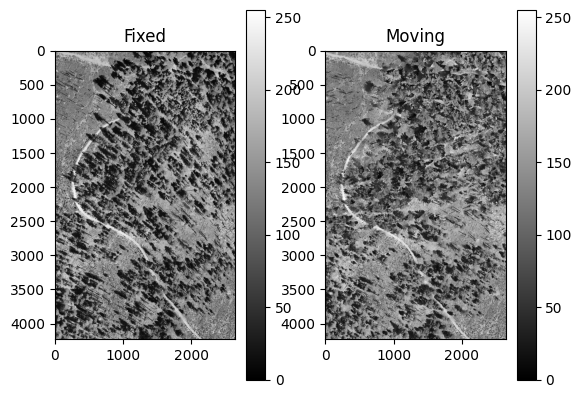

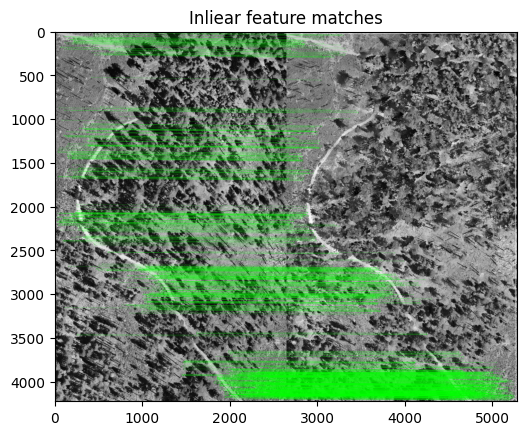

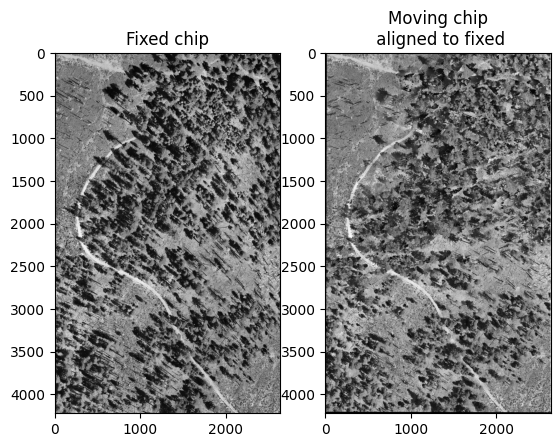

array([[ 2.38637609e-02, -6.36651339e-05,  6.59635179e+05],
       [-6.36435084e-05, -2.38619205e-02,  4.44441873e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [1]:
import geopandas as gpd

from GDRT.raster.register_images import align_two_rasters


FIXED_FILENAME = "/ofo-share/str-disp_drone-data-partial/cross-site/orthos/chips.tif"
MOVING_FILENAME = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/chips/02_photogrammetry/exports/chips_80m_only/chips_80m_only_20240102T0531_ortho_mesh.tif"
OUTFILE = "/ofo-share/repos-david/geospatial-data-registration-toolkit/scratch/chips_80m_only_20240102T0531_ortho_mesh_updated_georef.tif"
VECTOR_FILE = "/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/field_ref/crowns_drone_w_field_data.geojson"

BUFFER_METERS = 50
TARGET_GSD = 0.1

roi = gpd.read_file(VECTOR_FILE).query("fire=='chips'")
roi = roi.dissolve().buffer(BUFFER_METERS)

align_two_rasters(
    FIXED_FILENAME, MOVING_FILENAME, output_filename=OUTFILE,region_of_interest=roi, target_GSD=TARGET_GSD, vis_chips=True
)